In [2]:
%%capture
!pip install skforecast

In [3]:
%%capture
!pip install sktime

In [4]:
# Libraries
# ==============================================================================
import os
#os.environ["KERAS_BACKEND"] = "torch" # 'tensorflow', 'jax´ or 'torch'
os.environ["KERAS_BACKEND"] = "tensorflow" # 'tensorflow', 'jax´ or 'torch'
import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('once')

print(f"skforecast version: {skforecast.__version__}")
print(f"keras version: {keras.__version__}")

if keras.__version__ > "3.0":
    print(f"Using backend: {keras.backend.backend()}")
    if keras.backend.backend() == "tensorflow":
        import tensorflow
        print(f"tensorflow version: {tensorflow.__version__}")
    elif keras.backend.backend() == "torch":
        import torch
        print(f"torch version: {torch.__version__}")
    else:
        print("Backend not recognized. Please use 'tensorflow' or 'torch'.")

2024-10-23 05:33:39.203721: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


skforecast version: 0.13.0
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.17.0


In [5]:
url = (
    'https://raw.githubusercontent.com/saindata-bumi/webgis/refs/heads/main/datafull.csv'
)
#data = pd.read_csv(url)
data = pd.read_csv(url, sep=',', header=0, names=['waktu', 'SO2'])

data = data.set_index('waktu')
# Data preprocessing
# ==============================================================================


In [6]:
data

,SO2
waktu,
2020-03-30,2.110
2020-03-31,3.075
2020-04-01,3.075
2020-04-02,3.075
2020-04-03,-0.481
...,...
2024-09-15,3.580
2024-09-16,1.222
2024-09-17,1.105


In [7]:
end_train = "2023-03-26"
end_validation = "2024-05-13"
data_train = data.loc[:end_train, :].copy()
data_val = data.loc[end_train:end_validation, :].copy()
data_test = data.loc[end_validation:, :].copy()


# Multi Step Univariate

In [8]:
# Model creation
# ==============================================================================
series = ["SO2"] # Series used as predictors
levels = ["SO2"] # Target serie to predict
lags = 32 # Past time steps to be used to predict the target
steps = 5 # Future time steps to be predicted

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=50,
    dense_units=32,
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.17.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 5, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,197 (47.64 KB)

 Trainable params: 12,197 (47.64 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 3,  # Number of epochs to train the model.
        "batch_size": 4,  # Batch size to train the model.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_test,  # Validation data for model training.
    },
)    



/env/lib/python3.10/site-packages/skforecast/ForecasterRnn/ForecasterRnn.py:229: UserWarning: Setting `lags` = 'auto'. `lags` are inferred from the regressor architecture. Avoid the warning with lags=lags.
  warnings.warn(
/env/lib/python3.10/site-packages/skforecast/ForecasterRnn/ForecasterRnn.py:265: UserWarning: `steps` default value = 'auto'. `steps` inferred from regressor architecture. Avoid the warning with steps=steps.
  warnings.warn(


In [10]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/3
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0236 - val_loss: 0.0276
Epoch 2/3
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0130 - val_loss: 0.0275
Epoch 3/3
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0123 - val_loss: 0.0315


/env/lib/python3.10/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


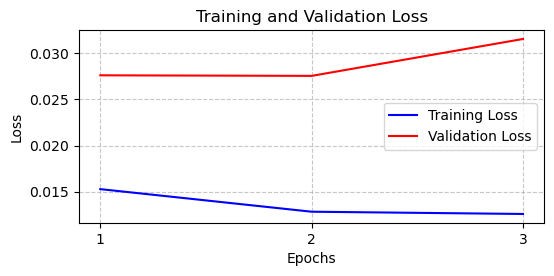

In [11]:
# Train and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
forecaster.plot_history(ax=ax)

In [12]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions

/env/lib/python3.10/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/env/lib/python3.10/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


,SO2
32,2.965013
33,3.062690
34,3.235394
35,2.668518
36,3.128229


In [107]:
# Specific step predictions
# ==============================================================================
predictions = forecaster.predict(steps=[1, 3])
predictions

/env/lib/python3.10/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/env/lib/python3.10/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


,SO2
32,1.917009
34,2.490502


In [13]:
# Backtesting 
# ==============================================================================
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.loc[:end_validation, :]),
    metric="mean_absolute_error",
    verbose=False,
    refit=False,
)

Epoch 1/3
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0130 - val_loss: 0.0281
Epoch 2/3
368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0121 - val_loss: 0.0294
Epoch 3/3
368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0121 - val_loss: 0.0304


/env/lib/python3.10/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


  0%|          | 0/26 [00:00<?, ?it/s]

/env/lib/python3.10/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/env/lib/python3.10/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/env/lib/python3.10/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/env/lib/python3.10/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/env/lib/python3.10/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/env/lib/python3.10/site-packages/s

TypeError: `span_index` must be a pandas DatetimeIndex or pandas RangeIndex.

In [59]:
# Backtesting predictions
# ==============================================================================
predictions

,SO2
32,1.859717
34,1.235671


KeyError: 'o3'

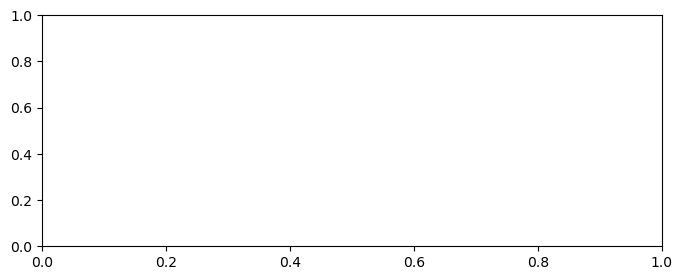

In [60]:
# Plotting predictions vs real values in the test set
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
data_test["o3"].plot(ax=ax, label="test")
predictions["o3"].plot(ax=ax, label="predictions")
ax.set_title("O3")
ax.legend();

In [61]:
# Backtesting metrics
# ==============================================================================
metrics

NameError: name 'metrics' is not defined

In [62]:
# % Error vs series mean
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Serie mean: {np.mean(data['o3']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")

NameError: name 'metrics' is not defined